In [1]:
#Check package versions, otherwise you don't have to run this cell
import iminuit
import numpy
import scipy
print("iminuit version", iminuit.__version__)
print("numpy version", numpy.__version__)
print("scipy version", scipy.__version__)

iminuit version 1.4.9
numpy version 1.20.2
scipy version 1.5.1


In [2]:
import pyximport
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

pyximport.install(
    setup_args=dict(
        include_dirs=[np.get_include()], 
    ),
    reload_support=True, 
) 
from Binned_LLH_cython import Binned_LLH, fit_func_for_plot, Initial_paramters

# Prepare data

Text(0.5, 0, 'Charge')

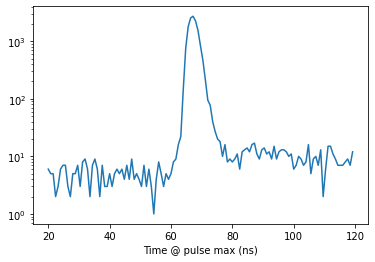

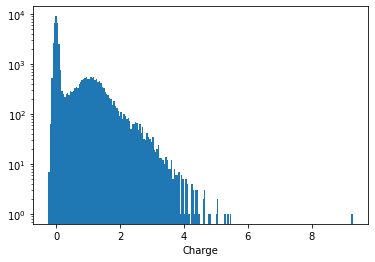

In [3]:
def gaussian(x,a,b,c):

    return a*np.exp(-(x-b)**2/(2.*c**2))


#bkc = charge of first 30ns of waveform, the pulses are normally ~70ns
#TT = time of pulse 
#charge = charge of pulse
#amp = amplitude of charge
bkc, TT, charge, amp = np.loadtxt("data_225.txt", usecols=(range(4)), unpack=1)

#Get charges of pulses in the interval [-6.5ns:60ns] from main peak
def clean(TT,charge,amp,bkc):
    h = np.histogram(TT[amp>4],bins = 125,range = (20,120))
    x = h[1][:-1]
    y = h[0]
    plt.figure()
    plt.plot(x,y)
    plt.xlabel("Time @ pulse max (ns)")
    plt.yscale("log")

    xmax = x[y==np.amax(y)][0]
    tmin = xmax-6.5
    tmax = xmax+60
    bols = np.logical_and(TT>tmin, TT< tmax)
    bols2 = np.invert(np.logical_and(TT>tmin, TT< tmax))
    nch = np.append(charge[bols], bkc[bols2])
    nch -= np.average(bkc)

    return nch


chclean = clean(TT,charge,amp,bkc)


h = np.histogram(chclean*1e12/(50), bins = 'sqrt')

bin_edges_data = h[1]
y = h[0]
plt.figure()
plt.hist(chclean*1e12/(50), bins = bin_edges_data)
plt.yscale("log")
plt.xlabel("Charge")




# Fit

In [4]:
#Bounds parameter space
limits = dict(limit_Q0 = (None,None),
          limit_s0 = (0.000000000001,None),
          limit_Q1 = (0.,None),
          limit_s1 = (0.000000000001,1),
          limit_poisson_mean = (0.0001,None),
          limit_height = (0.,1e6),
          limit_n_omega = (0.00001,1.0),
          limit_n_alpha = (0.0001,1.0))
#Initial estimate of errors, normally 10% of initial values is alright
error = dict(error_Q0 = .1,
         error_s0 = .05,
         error_Q1 = .5,
         error_s1 = .2,
         error_poisson_mean = .5,
         error_height = 0.,
         error_n_omega = .1,
         error_n_alpha = 1.)
#If parameter is fixed, it is left constant... height should always be the total nr of counts -> fix True
fix = dict(fix_Q0 = False,
         fix_s0 = False,
         fix_Q1 = False,
         fix_s1 = False,
         fix_poisson_mean = False,
         fix_height = True,
         fix_n_omega = False,
         fix_n_alpha = False)

#Get initial values, function in Binned_LLH_cython.pyx
p0 = Initial_paramters(bin_edges_data, y, np.mean(bkc), np.std(bkc)*1e12/(50))

#Class for data handling and llh in Binned_LLH_cython.pyx
mlh = Binned_LLH(bin_edges_data, y)
minuit_args = {**p0, **limits, **error, **fix, **dict(errordef= 0.5)}

#Pass mlh.compute, which calculates -log likelihood, to Minuit
m = Minuit(mlh.compute, **minuit_args)

m.tol = 1e-12
m.migrad() #Fits


------------------------------------------------------------------
| FCN = 412.1                   |     Ncalls=286 (286 total)     |
| EDM = 8.83e-12 (Goal: 1e-15)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------
| 0 | Q0           |  -6.9e-3  |  0.4e-3   |            |            |         |         |       |
| 1 | s0           | 51.46e-3  |  0.31e-3  |            |            |  1e-12  |         |       |
| 2 | Q1           |   1.050   |   0.008   |            |            |    0    |         |       |
| 3 | s1           |   0.379   |   0.008   |            |            |  1e-12  |    1    |       |
| 4 | poisson_mean |   0.357   |   0.011   |            |            | 0.0001  |         |       |
| 5 | height       | 4.4189e4  | 0.0000e4  |            |            |    0    |  1e+06  |  yes  |
| 6 | n_omega      |   0.105   |   0.009   |            |            |  1e-05  |    1    |       |
| 7 | n_alpha      |   0.44    |   0.05    |            |            | 0.0001  |    1    |       |
--------------------------------------------------------------------------------------------------

# Plotting

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


<IPython.core.display.Javascript object>


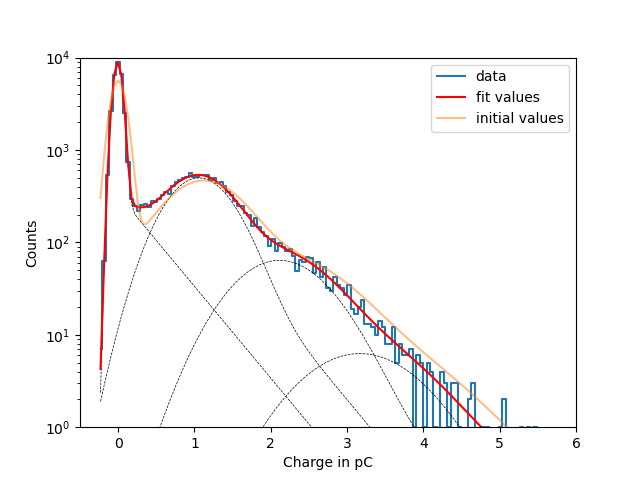

In [5]:
%matplotlib notebook
goodn = mlh.goodness_of_fit(*m.np_values())
 
xstep = (bin_edges_data[1]-bin_edges_data[0])*0.5
x = np.linspace(bin_edges_data[0]+xstep, bin_edges_data[-1]-xstep, y.size)

plt.figure()
plt.yscale("log")   
plt.step(x,y, label= "data", where = "mid")

#Plot single PE curves from 1 to 5 PE
n = 0
while True:
    yfit = []
    plot_args = {**m.values, **dict(N_start=n,N_stop=n+1)}
    for i in range(len(y)):
        yfit.append(fit_func_for_plot((bin_edges_data[i],bin_edges_data[i+1]), **plot_args))
    if np.amax(yfit) < 1 or n>5:
        break
    plt.plot(x, yfit, ls='--', color = 'black', lw = 0.5)
    n+=1

#Plot total fit
yfit = []
for i in range(len(x)):
    plot_args = {**m.values, **dict(N_start=0,N_stop=10)}
    yfit.append(fit_func_for_plot((bin_edges_data[i],bin_edges_data[i+1]), **plot_args))
plt.plot(x, yfit,  label = "fit values", color = "red")   




#Plot initial values
yfit = []
for i in range(len(x)):
    plot_args = {**p0, **dict(N_start=0,N_stop=10)}
    yfit.append(fit_func_for_plot((bin_edges_data[i],bin_edges_data[i+1]), **plot_args))
plt.plot(x, yfit, label = "initial values", alpha = 0.5)   


plt.ylim(1,1e4)
plt.xlim(-0.5, 6)
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Charge in pC')
plt.legend()

